In [64]:
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from io import StringIO
from math import sqrt
import numpy as np
import scipy.stats as st
from scipy.fftpack import fft, fftfreq
from scipy.signal import argrelextrema
import operator
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from time import time
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
def euclidean_norm(x, y, z):
  return sqrt(x**2 + y**2 + z**2)

def find_max_norm_index(df):
    max_norm_index = df.apply(lambda row: euclidean_norm(abs(row['acc_x']) + row['gyro_x'], abs(row['acc_y']) + row['gyro_y'], abs(row['acc_z']) + row['gyro_z']), axis=1).idxmax()
    time = df.loc[max_norm_index, 'time']
    return max_norm_index, time

def selected_signals_range(df, reference_time):
  return df[abs(df.index - reference_time) <= 500]


In [66]:
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            file_content = file.read()

        # Define the new column names
        new_headers = ["time", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

        df = pd.read_csv(StringIO(file_content), header=None, sep=';', names=new_headers, engine='python', skiprows=1)
        df['time'] = df['time'] - df.at[0, 'time']

        index, time = find_max_norm_index(df)
        return df, index, time

    except UnicodeDecodeError as e:
        print(f"Error decoding file {file_path}: {e}")

In [67]:
# Parameter: data series
def stat_features(ds):
  if ds.empty:
    raise ValueError("Input series is empty.")
  ds = np.array(ds).flatten()
  mean_ft = np.mean(ds).reshape(-1,1)           # mean
  min_ft = np.amin(ds).reshape(-1,1)            # min
  max_ft = np.amax(ds).reshape(-1,1)            # max
  range_ft = np.ptp(ds).reshape(-1,1)           # range (peak-to-peak)
  std_ft = np.std(ds).reshape(-1,1)             # standard deviation
  var_ft = np.var(ds).reshape(-1,1)             # variance
  skew_ft = st.skew(ds).reshape(-1,1)           # skewness
  kurtosis_ft = st.kurtosis(ds).reshape(-1,1)   # kurtosis
  iqr_ft = st.iqr(ds).reshape(-1,1)             # interquartile rante
  mad_ft = np.median(np.sort(abs(ds - np.median(ds)))).reshape(-1,1) # median absolute deviation

  return np.concatenate((mean_ft, min_ft, max_ft, range_ft, std_ft, var_ft, skew_ft, kurtosis_ft, iqr_ft, mad_ft), axis=1).flatten()


In [68]:
def make_feature_vector(data, Te=1.0):
  if data.empty:
    raise ValueError("Input series is empty.")
  acc_re = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
  gyro_re = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)

  # Raw signals
  features_acc_x = stat_features(data['acc_x'])
  features_acc_y = stat_features(data['acc_y'])
  features_acc_z = stat_features(data['acc_z'])
  features_acc_re = stat_features(acc_re)
  features_gyro_x = stat_features(data['gyro_x'])
  features_gyro_y = stat_features(data['gyro_y'])
  features_gyro_z = stat_features(data['gyro_z'])
  features_gyro_re = stat_features(gyro_re)

  # Jerk signals
  features_acc_x_jerk = stat_features(data['acc_x'].diff().dropna())
  features_acc_y_jerk = stat_features(data['acc_y'].diff().dropna())
  features_acc_z_jerk = stat_features(data['acc_z'].diff().dropna())
  features_acc_re_jerk = stat_features(acc_re.diff().dropna())
  features_gyro_x_jerk = stat_features(data['gyro_x'].diff().dropna())
  features_gyro_y_jerk = stat_features(data['gyro_y'].diff().dropna())
  features_gyro_z_jerk = stat_features(data['gyro_z'].diff().dropna())
  features_gyro_re_jerk = stat_features(gyro_re.diff().dropna())

  return np.concatenate((features_acc_x, features_acc_y, features_acc_z, features_acc_re,
                         features_gyro_x, features_gyro_y, features_gyro_z, features_gyro_re,
                         features_acc_x_jerk, features_acc_y_jerk, features_acc_z_jerk, features_acc_re_jerk,
                         features_gyro_x_jerk, features_gyro_y_jerk, features_gyro_z_jerk, features_gyro_re_jerk), axis=0)

In [69]:
def read_data(folder_path):
  feature_vectors = []
  label = 1 if folder_path.endswith('Falling') else -1
  # Duyệt qua tất cả các thư mục và file trong thư mục gốc
  for root, dirs, files in os.walk(folder_path):
      for file in files:
        try:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                user_id = file[:3]
                df, index, time = read_file(file_path)
                df.set_index('time', inplace=True)
                feature_vector = make_feature_vector(selected_signals_range(df, time))
                feature_vectors.append(np.append(feature_vector, [label, user_id]))
                print(f"Processed file: {file_path}")
        except ValueError as error:
            print(f"Error processing file {file_path}: {error}")

  feature_matrix = np.vstack(feature_vectors)
  return feature_matrix

In [70]:
fvs_falling = read_data('/content/drive/MyDrive/FallDetectionAI/Dataset/Falling')
fvs_adl = read_data('/content/drive/MyDrive/FallDetectionAI/Dataset/ADL')
fvs = np.concatenate((fvs_falling, fvs_adl), axis=0)

Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P03_07.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P02_06.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P04_07.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P06_08.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P08_05.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P06_03.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P02_08.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P01_02.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P08_01.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P05_09.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/Dataset/Falling/F05/P07_06.txt
Processed file: /content/drive/MyDrive/FallDetectionAI

In [71]:
fvs[0]

array(['5.045648148148148', '-24.1766', '16.5703', '40.7469',
       '6.528431091186696', '42.620412512373115', '-1.7716292686534603',
       '5.958918990098006', '4.108499999999999', '2.0926',
       '-10.32021975308642', '-45.7532', '14.6429', '60.3961',
       '11.206037501115189', '125.57527647639995', '-0.3899908321127103',
       '1.3608389941801793', '8.482600000000001', '4.199400000000001',
       '3.426548148148148', '-2.2098', '36.3488', '38.5586',
       '5.304157491379829', '28.134086693360768', '3.878651798891071',
       '19.232154495472642', '3.0046999999999997', '1.5993',
       '16.032061611771304', '4.534998664828911', '53.95883307485439',
       '49.42383441002548', '9.110955457963021', '83.00950935698617',
       '2.1450614801758197', '5.4592291367301655', '7.595102550754566',
       '3.8340330147055504', '1.684995061728395', '-1.4053', '4.3656',
       '5.770899999999999', '1.8755468136908724', '3.517675850345984',
       '0.2851622938267423', '-1.4403644717218476'

In [72]:
def header_stat(feature, type):
  end = '_' + feature + '_' + type
  base_headers = ['mean', 'min', 'max', 'range', 'std', 'var', 'skew', 'kurtosis', 'iqr', 'mad']
  headers = [header + end for header in base_headers]
  return headers

headers = np.concatenate((header_stat('acc_x', 'raw'), header_stat('acc_y', 'raw'), header_stat('acc_z', 'raw'), header_stat('acc_re', 'raw'),
                          header_stat('gyro_x', 'raw'), header_stat('gyro_y', 'raw'), header_stat('gyro_z', 'raw'), header_stat('gyro_re', 'raw'),
                          header_stat('acc_x', 'jerk'), header_stat('acc_y', 'jerk'), header_stat('acc_z', 'jerk'), header_stat('acc_re', 'jerk'),
                          header_stat('gyro_x', 'jerk'), header_stat('gyro_y', 'jerk'), header_stat('gyro_z', 'jerk'), header_stat('gyro_re', 'jerk'),
                          ['fall_adl_bin', 'person_id']), axis=0)

print(len(headers))

162


In [73]:
df = pd.DataFrame(fvs, columns=headers)

In [74]:
df.head()

,mean_acc_x_raw,min_acc_x_raw,max_acc_x_raw,range_acc_x_raw,std_acc_x_raw,var_acc_x_raw,skew_acc_x_raw,kurtosis_acc_x_raw,iqr_acc_x_raw,mad_acc_x_raw,...,max_gyro_re_jerk,range_gyro_re_jerk,std_gyro_re_jerk,var_gyro_re_jerk,skew_gyro_re_jerk,kurtosis_gyro_re_jerk,iqr_gyro_re_jerk,mad_gyro_re_jerk,fall_adl_bin,person_id
0,5.045648148148148,-24.1766,16.5703,40.7469,6.528431091186696,42.620412512373115,-1.7716292686534603,5.958918990098006,4.108499999999999,2.0926,...,1.3504117173662213,3.811666751908176,0.4263289634283266,0.18175638505787145,-1.5255461999910285,13.936863386970508,0.2598029952567678,0.11846243365409298,1,P03
1,6.087624691358025,-6.2896,11.9183,18.207900000000002,3.5820211835485196,12.830875759390336,-1.180510268867433,1.7765660816369895,3.9719000000000007,1.8627000000000002,...,1.7745125505671906,3.6828957685453627,0.465557547606742,0.21674383013360385,-0.8948482022293128,8.212070477229723,0.14075662969603553,0.07282838222827692,1,P02
2,10.610082926829271,3.8858,34.8979,31.0121,6.313770986073739,39.86370406458656,2.3569138767336697,5.741394120360033,4.4041749999999995,2.2864999999999998,...,0.6058391577183291,2.5813163598594584,0.26756649878414573,0.07159183127160625,-4.461852244132396,33.7753268296554,0.10605791501328721,0.05506180738022204,1,P04
3,6.354674390243901,0.6656,12.6725,12.0069,2.3776487135049926,5.653213404831946,0.24092674805738545,0.13854368708471387,2.6910500000000006,1.5071499999999998,...,3.6727903094515857,5.813601375392304,0.5646757348448204,0.3188586855225378,2.6371635941552687,22.491136034019128,0.15549104344776965,0.0908906983720475,1,P06
4,6.09246626506024,-20.0658,18.7801,38.8459,6.106832390042056,37.29340184006677,-1.7437139154904329,6.83375058570812,1.6723499999999998,0.8259999999999996,...,1.0088076940532233,1.9126809064717922,0.2600563711482266,0.06762931617478418,-0.3243690116463551,4.624551826784157,0.1720569159604095,0.07684523340451355,1,P08


In [75]:
df['person_id'].unique()

array(['P03', 'P02', 'P04', 'P06', 'P08', 'P01', 'P05', 'P07'],
      dtype=object)

<Axes: xlabel='person_id', ylabel='count'>

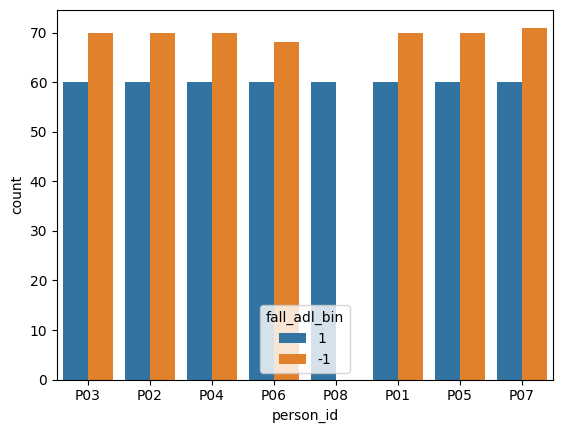

In [76]:
sns.countplot(x='person_id', data=df, hue='fall_adl_bin')

<Axes: xlabel='fall_adl_bin', ylabel='count'>

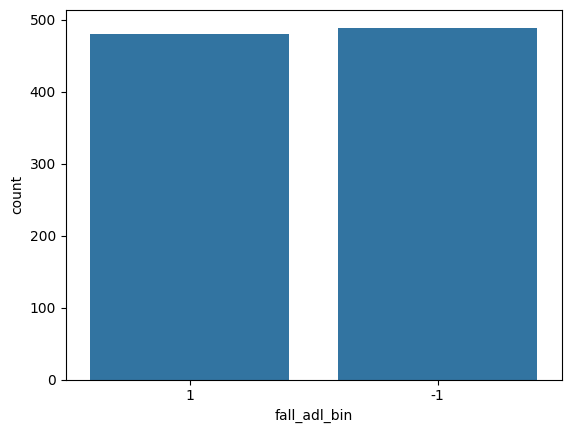

In [77]:
sns.countplot(x='fall_adl_bin', data=df)

# 2 problems with existing dataset that may cause imbalance in data


*   Person 8th only has fall, no adl
*   For every person, the number of fall and adl activity is not equal

=> Remove person 8th, randomly remove 10 adl for the remaining 7 people





In [78]:
df = df[df['person_id'] != "P08"]


<Axes: xlabel='person_id', ylabel='count'>

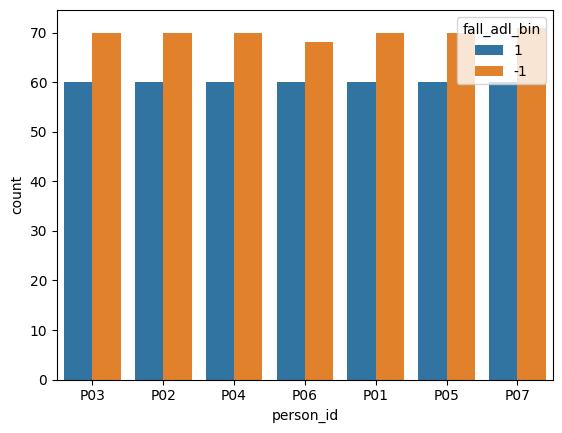

In [79]:
sns.countplot(x='person_id', data=df, hue='fall_adl_bin')

In [80]:
def remove_random_rows(df, target_column, target_value, n_remove, group_column):
    """
    Randomly removes rows from a DataFrame where a specified column equals a target value,
    ensuring that n_remove rows are removed for each unique value in the group_column.

    Parameters:
    - df: DataFrame to modify.
    - target_column: The column to check for the target value.
    - target_value: The value to filter rows for removal.
    - n_remove: Number of rows to remove per group.
    - group_column: The column used to group the DataFrame.

    Returns:
    - A DataFrame with the rows removed.
    """
    def remove_from_group(group):
        # Filter rows where the target column matches the target value
        rows_to_remove = group[group[target_column] == target_value]
        # Sample n_remove rows randomly
        if len(rows_to_remove) > n_remove:
            drop_indices = rows_to_remove.sample(n=n_remove).index
            return group.drop(drop_indices)
        return group

    # Apply the function to each group
    return df.groupby(group_column, group_keys=False).apply(remove_from_group)

In [81]:
result_df = remove_random_rows(df, target_column='fall_adl_bin', target_value='-1', n_remove=10, group_column='person_id')

<ipython-input-80-4a43f2af7480>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_column, group_keys=False).apply(remove_from_group)


<Axes: xlabel='person_id', ylabel='count'>

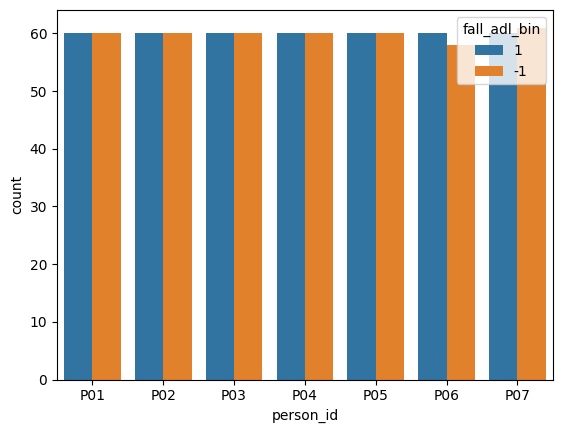

In [82]:
sns.countplot(x='person_id', data=result_df, hue='fall_adl_bin')

In [83]:
result_df.to_csv('/content/drive/MyDrive/FallDetectionAI/Dataset/updated_dataset_raw.csv', index=False)

In [87]:
new_df = result_df[['max_acc_re_raw', 'std_acc_re_raw', 'var_acc_re_raw', 'iqr_acc_re_raw', 'mad_acc_re_raw', 'max_acc_re_jerk', 'min_acc_re_jerk', 'range_acc_re_jerk', 'std_acc_re_jerk', 'var_acc_re_jerk', 'mad_acc_re_jerk', 'max_gyro_re_raw', 'std_gyro_re_raw', 'var_gyro_re_raw', 'iqr_gyro_re_raw', 'mad_gyro_re_raw', 'max_gyro_re_jerk', 'min_gyro_re_jerk', 'range_gyro_re_jerk', 'std_gyro_re_jerk', 'var_gyro_re_jerk', 'mad_gyro_re_jerk', 'fall_adl_bin', 'person_id']]


In [86]:
new_df.head()

,max_acc_re_raw,std_acc_re_raw,var_acc_re_raw,iqr_acc_re_raw,mad_acc_re_raw,max_acc_re_jerk,min_acc_re_jerk,range_acc_re_jerk,std_acc_re_jerk,var_acc_re_jerk,...,iqr_gyro_re_raw,mad_gyro_re_raw,max_gyro_re_jerk,min_gyro_re_jerk,range_gyro_re_jerk,std_gyro_re_jerk,var_gyro_re_jerk,mad_gyro_re_jerk,fall_adl_bin,person_id
7,76.03689612214586,10.008717994973514,100.17443590290664,5.566221154158743,2.9402099579703798,39.91359420080982,-36.0251118789604,75.93870607977021,6.74697649738472,45.52169185626179,...,1.4499721885009873,0.6982639427591012,1.4851221613292762,-2.1855084720847024,3.6706306334139787,0.4836182886970786,0.23388664916229088,0.22180430215213917,1,P01
14,27.640773932182146,5.992466629353258,35.9096563039124,10.007666432087358,3.9661843697429706,11.271461423494632,-14.967072106748505,26.23853353024314,3.7534070139638636,14.088064212473126,...,2.765061404948387,1.2056258681171417,2.221514508522196,-1.4996928669312442,3.72120737545344,0.49941635017065394,0.24941669081777723,0.11765457104462496,1,P01
18,37.25784579306753,6.346144039995892,40.27354417637538,9.312718865045346,3.7107826865122684,19.88815418441977,-8.400244341172488,28.288398525592257,3.2182988724869643,10.357447632650867,...,1.4878174027861593,0.8340274840303437,3.229411486067704,-1.4264272966285023,4.655838782696207,0.5116174659775562,0.2617524314932959,0.14398796727461957,1,P01
35,93.61089008171004,10.095335378508537,101.9157964045661,7.51841508652911,3.99990229926215,75.8249779203954,-69.05364028618122,144.87861820657662,12.108990923586022,146.62766118748868,...,2.265149563146516,1.091244288337609,3.7869736933778944,-2.523515865317089,6.310489558694983,0.7438343614510212,0.5532895572752484,0.2961614284313579,1,P01
63,54.81808864471653,9.130828646607958,83.3720317737165,4.909635945454735,1.666574963997073,19.1171492328302,-27.57683383762727,46.69398307045747,5.637665756754354,31.783275184880644,...,2.906404770765758,0.8773406572218221,3.295670061722661,-1.0483498666151765,4.344019928337838,0.607688430185752,0.36928522818162357,0.0757926940949614,1,P01


In [88]:
new_df.to_csv('/content/drive/MyDrive/FallDetectionAI/Dataset/updated_dataset_extract.csv')